In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict

In [3]:
#Loading dataset
wine = pd.read_csv('winequality-red.csv')

In [4]:
bins = (2, 5.5, 8)
group_names = ['bad', 'good']
#here 2-5.5 is an interval with corresponding label bad, and 5.5-8 is an interval with corresponding label good.
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)
#we want to categorize the wine quality

In [5]:
wine['quality'].unique()

[bad, good]
Categories (2, object): [bad < good]

In [6]:
# to encode bad as 0 and good as 1, use the sklearn preprocessing function
label_quality = LabelEncoder()
wine['quality'] = label_quality.fit_transform(wine['quality'])

In [7]:
# count number of good and bad quality wines
wine['quality'].value_counts()

1    855
0    744
Name: quality, dtype: int64

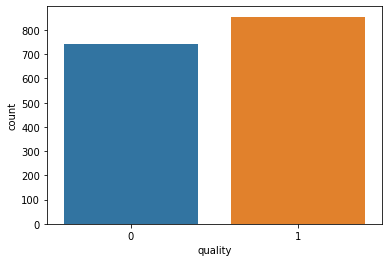

In [8]:
#bar plot using Seaborn package
sns.countplot(wine['quality'])
#bar plot showing number of bad quality wine (with blue) and the number of good quality wine (with orange)

In [56]:
# Dividing dataset into predictor (X) and response features (y)
X = wine.drop('quality', axis = 1) # axis = 0 means row; axis = 1 means columns; so here we select all columns except quality
y = wine['quality']
# Split into train and test datasets (using sklearn package)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # using 20% of data for testing hence 0.2; random state is like setting a seed
# We scale the data using standardized scaling so that columns with higher numerical values (eg. total sulphur dioxide) are not biased compared to columns with very small numerical values (e.g. chlorides)
sc = StandardScaler()
X_train = sc.fit_transform(X_train) #fit_transform is gonna fit AND transform at the same time, much like label encoder
X_test = sc.transform(X_test) # we want the same fit (i.e. values of mean and standard deviation for each column) that we used for (centering the) training data so instead of fit_transform() (which internally calls fit() followed by transform()), we just use transform()

In [ ]:
#Decision Tree

In [10]:
dtc = DecisionTreeClassifier()
#fit
dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)
accuracy_score(pred_dtc, y_test)
#accuracy is 0.7093

0.709375

In [29]:
# As of now decision tree classifier was created using default values, but now lets try to figure out the 'best' hyperparameters

parameter_candidates = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf' :list(range(2,10)),
    'max_depth': list(range(2,10))
}

grid_dtc = GridSearchCV(estimator = dtc, param_grid= parameter_candidates, scoring= 'accuracy', cv = 5)
grid_dtc.fit(X_train, y_train)
grid_dtc.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4}

In [30]:
# Recreating the dtc model but with the new hyperparameters obtained
dtc2 = DecisionTreeClassifier(criterion= 'gini', max_depth = 5, min_samples_leaf= 4)
dtc2.fit(X_train, y_train)
pred_dtc2 = dtc2.predict(X_test)
#check accuracy of new model
accuracy_score(pred_dtc2, y_test) 
#the best accuracy achieved after parameter tuning via grid search is 0.725

0.725

In [51]:
print(confusion_matrix(y_test,pred_dtc2))

[[108  33]
 [ 55 124]]


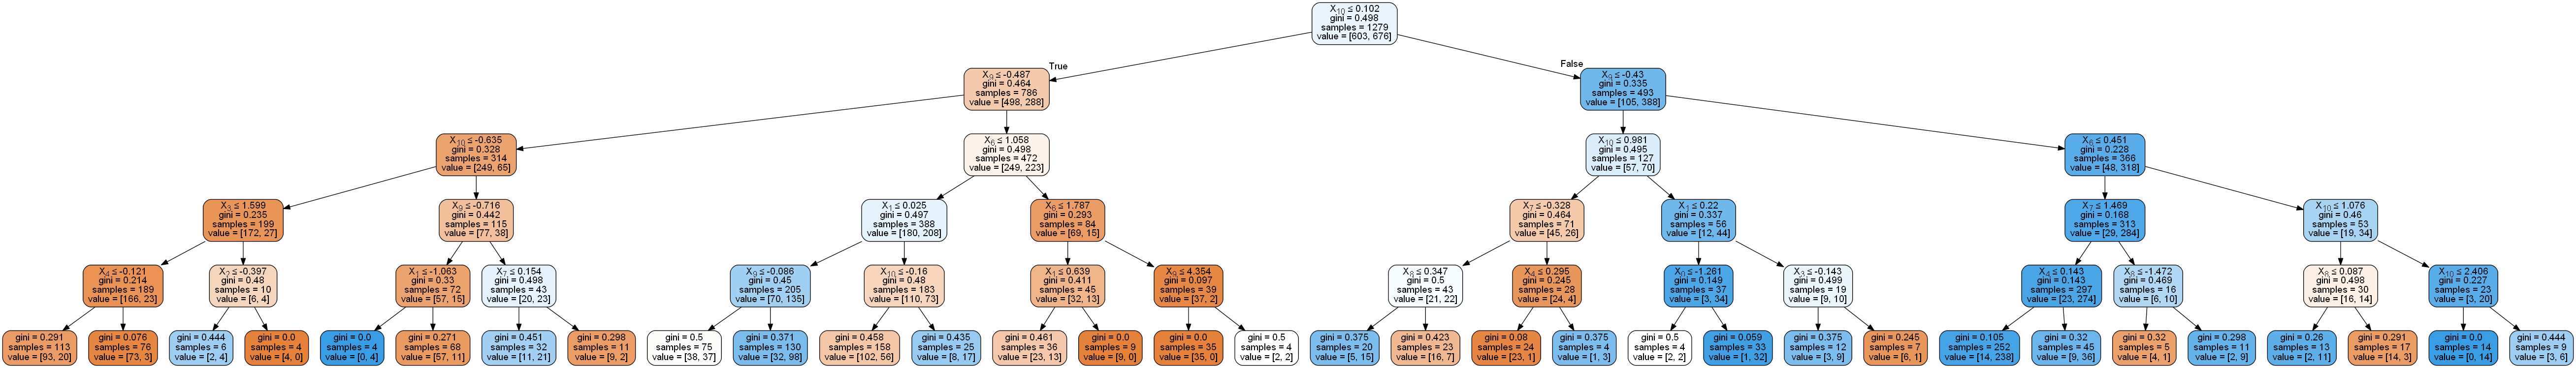

In [58]:
from sklearn.externals.six import StringIO  
#from IPython.display import Image  
from sklearn.tree import export_graphviz
import matplotlib.image as mpimg
import pydotplus
import io

#dot_data1=export_graphviz(dtc2,out_file=None,max_depth=2,feature_names=list(X.column.values),filled=True,rounded=True)
#valgTre=graphviz.Source(dot_data)
#ValgTre
dot_data = StringIO()
export_graphviz(dtc2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
#fil="tree.png"

graph=pydotplus.graph_from_dot_data(dot_data.getvalue())#.write_png(fil)
#plt.figure(figsize=(18,18))
#plt.rcParams['figure.dpi']=400
#img=mpimg.imread(fil)
#imgplot=plt.imshow(img)
#plt.show()
Image(graph.create_png())

In [ ]:
#Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
accuracy_score(y_pred, y_test) 
#accuracy using random forest classifier is 0.771875

0.771875

In [62]:
from sklearn.metrics import roc_curve, auc
false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test,y_pred)
roc_auc=auc(false_positive_rate,true_positive_rate)
roc_auc
#the value 0.77501 means that there is 77.501% chance that model will be able to distinguish between positive class and negative class


0.7750108958358095

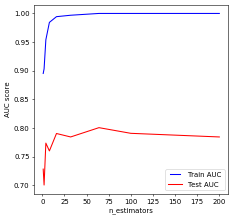

In [73]:
n_estimators=[1,2,4,8,16,32,64,100,200]
train_results=[]
test_results=[]
for estimators in n_estimators:
    rf=RandomForestClassifier(n_estimators=estimators,n_jobs=-1)
    rf.fit(X_train,y_train)
    train_pred=rf.predict(X_train)
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_train,train_pred)
    roc_auc=auc(false_positive_rate,true_positive_rate)
    train_results.append(roc_auc)
    y_pred=rf.predict(X_test)
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate,true_positive_rate)
    test_results.append(roc_auc)
line1,=plt.plot(n_estimators,train_results,'b',label="Train AUC")
line2,=plt.plot(n_estimators,test_results,'r',label="Test AUC")
from matplotlib.legend_handler import HandlerLine2D
plt.rcParams['figure.figsize']=[5,5]
plt.rcParams['figure.dpi']=10
plt.legend(handler_map={line1:HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
#upto 64 estimators the AUC score (almost) increases.
#next we consider estimators till 64


In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
RF_clf=RandomForestClassifier(random_state=5,n_estimators=64)
cv_scores=cross_val_score(RF_clf,X_train,y_train,cv=10,scoring='accuracy')
print('The accuracy scores for the iterations are {}'.format(cv_scores))
print('The mean accuracy scores for the iterations are {}'.format(cv_scores.mean()))

The accuracy scores for the iterations are [0.80620155 0.78294574 0.84496124 0.765625   0.765625   0.828125
 0.81889764 0.84251969 0.84251969 0.85826772]
The mean accuracy scores for the iterations are 0.8155688251541232


In [79]:
RF_clf.fit(X_train,y_train)
pred_RF=RF_clf.predict(X_test)
print(accuracy_score(y_test,pred_RF))
#accuracy of the random forest classifier when n_estimators = 64 is 0.79375

0.79375


In [80]:
print(confusion_matrix(y_test,pred_RF))

[[109  32]
 [ 34 145]]


In [ ]:
#NaiveBayes

In [84]:
from sklearn.naive_bayes import GaussianNB
#create a gaussian classifier
nb=GaussianNB()
nb.fit(X_train,y_train)
nb_predict=nb.predict(X_test)
print(accuracy_score(y_test,nb_predict))
print(confusion_matrix(y_test,nb_predict))
#accuracy when considering the naive bayes classifier is 0.734375

0.734375
[[ 97  44]
 [ 41 138]]


In [ ]:
#in conclusion, we are getting a better accuracy on considering random forest classifier with 64 estimators.